This notebook simulates the effect of spill-back in CMOS detectors. Spill-back occurs during readout of a CMOS detector, when a large enough amount of charge has accumulated on the floating diffusion mode such that the floating diffusion node and transfer gate are equipotential. Some excess charge may then sit on the transfer gate and may "spill back" over to the pinned photodiode when the transfer gate is reset. This leads to image lag and a nonlinear photon transfer curve.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict, get_mean_images
from defect_pixel_funcs import *
from scipy.optimize import curve_fit

In [2]:
def spill_back(electrons, spill_cut_on, spill_back_frac):
    if electrons > spill_cut_on:
        return electrons - (electrons - spill_cut_on) * spill_back_frac
    else:
        return electrons

Simulate the effects of spill-back on a linearity curve and on a photon transfer curve.

In [3]:
num_levels = 100
# Number of photons striking the sensor
illumination_levels = np.linspace(0, 1000, num_levels)
# Quantum efficiency of the sensor
qe = 1
# Gain, in ADU/electron
gain = 3
# Read noise, in electrons
read_noise = 10
# Onset of the spill-back regime, in electrons
spill_back_onset = 300
# Fraction of charge above the spill-back threshold that is spilled back into the pixel
spill_back_frac = 0.05
# Number of readings at each illumination level
num_readings = 100000
# Full well capacity, in ADU
full_well = 2048
num_photoelectrons = np.random.poisson(illumination_levels, np.array([num_readings, num_levels])).transpose()
num_photoelectrons = np.vectorize(spill_back)(num_photoelectrons, spill_back_onset, spill_back_frac)
measured_signals = (num_photoelectrons + np.random.normal(0, read_noise, num_readings)) * gain
measured_signals = np.clip(measured_signals, 0, full_well)
signal_means = np.mean(measured_signals, axis=1)
signal_vars = np.var(measured_signals, axis=1)

In [ ]:
%matplotlib inline
plt.plot(illumination_levels, signal_means, 'o')
# Fit points below spill-back threshold
popt1, pcov1 = curve_fit(lambda x, a, b: a * x + b, illumination_levels[illumination_levels < spill_back_onset], signal_means[illumination_levels < spill_back_onset])
plt.plot(illumination_levels[illumination_levels < spill_back_onset], popt1[0] * illumination_levels[illumination_levels < spill_back_onset] + popt1[1], 'r')
plt.text(0.5, 0.5, 'Slope: {:.2f}'.format(popt1[0]), transform=plt.gca().transAxes)
# plt.text(0.5, 0.5, 'Slope of first part: {:.2f}'.format(popt1[0]), transform=plt.gca().transAxes)
second_part_range = (illumination_levels > spill_back_onset) & (signal_means < 0.9 * full_well)
popt2, pcov2 = curve_fit(lambda x, a, b: a * x + b, illumination_levels[second_part_range], signal_means[second_part_range])
plt.plot(illumination_levels[second_part_range], popt2[0] * illumination_levels[second_part_range] + popt2[1], 'r')
plt.text(0.5, 0.4, 'Slope of second part: {:.2f}'.format(popt2[0]), transform=plt.gca().transAxes)
plt.text(0.5, 0.3, 'Ratio of slopes: {:.2f}'.format(popt2[0] / popt1[0]), transform=plt.gca().transAxes)
plt.text(0.5, 0.2, 'Actual Spill-Back Fraction: {:.2f}'.format(spill_back_frac), transform=plt.gca().transAxes)
plt.xlabel('Number of photons')
plt.ylabel('Signal (ADU)')
plt.title('Linearity Plot: Simulated Data')
# plt.axhline(spill_back_onset * gain, color='g', linestyle='--')
# plt.text(50, spill_back_onset * gain + 50, 'Spill-back onset', color='g')
plt.axhline(full_well, color='orange', linestyle='--')
plt.text(50, full_well + 10, 'Saturation', color='orange')
plt.show()

In [ ]:
%matplotlib inline
fit_points_x = signal_means[(signal_means > 0.05 * full_well) & (signal_means < 0.9 * full_well)]
fit_points_y = signal_vars[(signal_means > 0.05 * full_well) & (signal_means < 0.9 * full_well)]
# fit_points_x = signal_means[(signal_means > 0.05 * full_well) & (signal_means < 0.9 * spill_back_onset * gain)]
# fit_points_y = signal_vars[(signal_means > 0.05 * full_well) & (signal_means < 0.9 * spill_back_onset * gain)]
popt, pcov = curve_fit(lambda x, a, b: a*x + b, fit_points_x, fit_points_y)
fit_points_x_2 = signal_means[(signal_means > 1.05 * spill_back_onset * gain) & (signal_means < 0.9 * full_well)]
fit_points_y_2 = signal_vars[(signal_means > 1.05 * spill_back_onset * gain) & (signal_means < 0.9 * full_well)]
popt2, pcov2 = curve_fit(lambda x, a, b: a*x + b, fit_points_x_2, fit_points_y_2)
plt.plot(signal_means, signal_vars, 'o')
plt.xlabel('Mean signal (ADU)')
plt.ylabel('Variance of signal (ADU^2)')
plt.plot(fit_points_x, popt[0] * fit_points_x + popt[1], 'r')
plt.text(0.5, 0.2, f'Slope: {popt[0]:.2f}', transform=plt.gca().transAxes)
# plt.plot(fit_points_x_2, popt2[0] * fit_points_x_2 + popt2[1], 'r')
# plt.text(0.5, 0.3, f'Slope of First Part: {popt[0]:.2f}', transform=plt.gca().transAxes)
# plt.text(0.5, 0.2, f'Slope of Second Part: {popt2[0]:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.1, f'Actual Gain: {gain}', transform=plt.gca().transAxes)
plt.title('Photon Transfer Curve: Simulated Data')
# plt.axvline(spill_back_onset * gain, color='g', linestyle='--')
# plt.text(spill_back_onset * gain + 10, 1500, 'Spill-back onset', rotation=90, verticalalignment='center', color='g')
plt.axvline(full_well, color='orange', linestyle='--')
plt.text(full_well + 10, 1500, 'Saturation', rotation=90, verticalalignment='center', color='orange')
plt.show()

Look at COSMOS data

In [2]:
dark_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark'
dark_stacks = get_stacks(dark_folder, get_mean_img=True, get_var_img=True, num_imgs=0, datatype='int')
# gray_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Light'
# gray_stacks = get_stacks(gray_folder, get_mean_img=True, get_var_img=True, num_imgs=0, datatype='int')
for i, stack in enumerate(dark_stacks):
    stack['mean_img'] = stack['mean_img'].tolist()
    stack['var_img'] = stack['var_img'].tolist()
    # Create file dark_stacks.json if it doesn't exist
# with open('gray_stacks.json', 'w') as f:
#     json.dump(gray_stacks, f)
with open('dark_stacks.json', 'w') as f:
    json.dump(dark_stacks, f)


Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark/HSHG_RS_dark_320ms_-25C 2024-10-05 21_30_27.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark/HSHG_RS_dark_9600ms_-25C 2024-10-05 23_22_16.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark/HSHG_RS_dark_220ms_-25C 2024-10-05 21_28_36.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark/HSHG_RS_dark_720ms_-25C 2024-10-05 21_39_13.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark/HSH

In [3]:
# load dark_stacks.json and gray_stacks.json
dark_stacks = json.load(open('dark_stacks.json'))
gray_stacks = json.load(open('gray_stacks.json'))
# Convert lists to arrays
for i in range(104):
    dark_stacks[i]['mean_img'] = np.array(dark_stacks[i]['mean_img'])
    dark_stacks[i]['var_img'] = np.array(dark_stacks[i]['var_img'])
    gray_stacks[i]['mean_img'] = np.array(gray_stacks[i]['mean_img'])
    gray_stacks[i]['var_img'] = np.array(gray_stacks[i]['var_img'])

In [150]:
# Sort dark_stacks and gray_stacks by exposure time
dark_stacks = sorted(dark_stacks, key=lambda x: float(x['exposure_ms']))
gray_stacks = sorted(gray_stacks, key=lambda x: float(x['exposure_ms']))
exp_times = np.zeros(len(gray_stacks))
mean_list = np.zeros(len(gray_stacks))
var_list = np.zeros(len(gray_stacks))
for i, gray_stack in enumerate(gray_stacks):
    exp_time_ms = float(gray_stack['exposure_ms'])
    mean_val = gray_stack['mean_img_mean'] - dark_stacks[i]['mean_img_mean']
    var_val = gray_stack['var_img_mean'] + dark_stacks[i]['var_img_mean']
    exp_times[i] = exp_time_ms
    mean_list[i] = mean_val
    var_list[i] = var_val

In [ ]:
# A function to find where there is a "kink" in a plot of x vs y.
# This kink should occur at the spill-back threshold.
def find_spill_back_threshold(x, y):
    dy = np.gradient(y, x)
    d2y = np.gradient(dy, x)
    # If no negative numbers of sufficient absolute value, return the last index
    if np.min(d2y) > -1e-5:
        kink_idx = None
        print('No spill-back identified')
    else:
        kink_idx = np.argmin(d2y)
        print('Spill-back threshold: ', format(int(y[kink_idx]), '3d'), ' ADU')
    return kink_idx

bits = 18
low_lim = np.rint(np.max(mean_list) * 0.25)
high_lim = np.rint(np.max(mean_list) * 0.75)
fit_exp_times = exp_times[(mean_list > low_lim) & (mean_list < high_lim)]
fit_mean_list = mean_list[(mean_list > low_lim) & (mean_list < high_lim)]
fit_var_list = var_list[(mean_list > low_lim) & (mean_list < high_lim)]
threshold_idx = find_spill_back_threshold(fit_exp_times, fit_mean_list)
threshold_idx = None

In [ ]:
%matplotlib inline
plt.plot(exp_times, mean_list, 'o', markersize=3)
if threshold_idx is not None:
    plt.axhline(fit_mean_list[threshold_idx], color='g', linestyle='--')
    plt.text(3000, fit_mean_list[threshold_idx] + 200, 'Fit spill-back threshold', color='g')
    popt1, pcov1 = curve_fit(lambda x, a, b: a * x + b, fit_exp_times[:threshold_idx], fit_mean_list[:threshold_idx])
    plt.plot(fit_exp_times[:threshold_idx], popt1[0] * fit_exp_times[:threshold_idx] + popt1[1], c='r')
    plt.text(0.5, 0.3, f'Slope of first part: {popt1[0]:.2f}', transform=plt.gca().transAxes)
    popt2, pcov2 = curve_fit(lambda x, a, b: a * x + b, fit_exp_times[threshold_idx:], fit_mean_list[threshold_idx:])
    plt.plot(fit_exp_times[threshold_idx:], popt2[0] * fit_exp_times[threshold_idx:] + popt2[1], c='r')
    plt.text(0.5, 0.2, f'Slope of second part: {popt2[0]:.2f}', transform=plt.gca().transAxes)
    plt.text(0.5, 0.1, f'Ratio of slopes: {popt2[0]/popt1[0]:.2f}', transform=plt.gca().transAxes)
else:
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, fit_exp_times, fit_mean_list)
    # Dotted line
    plt.plot(exp_times, popt[0] * exp_times + popt[1], c='r', linestyle='--')
    plt.plot(fit_exp_times, popt[0] * fit_exp_times + popt[1], c='r')
    plt.text(0.5, 0.3, f'Slope of fit: {popt[0]:.2f}', transform=plt.gca().transAxes)
    plt.text(0.5, 0.2, f'No spill-back identified', transform=plt.gca().transAxes)
bits = 14
plt.axhline(2**bits - 1, color='orange', linestyle='--')
plt.text(3000, 2**bits - 1 + 200, 'Saturation', color='orange')
plt.xlabel('Exposure time (ms)')
plt.ylabel('Mean signal (ADU)')
plt.ylim(0, 2**bits * 1.1)
plt.title('Linearity Plot')
label_plot(gray_stacks[0])
plt.show()
# # Plot residuals
# if threshold_idx is not None:
#     residuals = (mean_list - popt[0] * exp_times - popt[1]) / (popt[0] * mean_list + popt[1])
# else:
#     residuals = (mean_list - popt[0] * exp_times - popt[1]) / (popt[0] * exp_times + popt[1])
# plt.plot(exp_times, residuals, 'o')
# plt.xlabel('Exposure time (ms)')
# plt.ylabel('Residuals (%)')
# plt.title('Residuals of Linearity Fit')
# plt.show()

In [ ]:
plt.plot(mean_list, var_list, 'o', markersize=5)
label_plot(gray_stacks[0])
if threshold_idx is not None:
    popt3, pcov3 = curve_fit(lambda x, a, b: a * x + b, fit_mean_list[:threshold_idx], fit_var_list[:threshold_idx])
    plt.plot(fit_mean_list[:threshold_idx], popt3[0] * fit_mean_list[:threshold_idx] + popt3[1], c='r')
    plt.axvline(fit_mean_list[threshold_idx], color='g', linestyle='--')
    plt.text(fit_mean_list[threshold_idx] + 200, 500, 'Fit spill-back threshold', color='g', rotation=90)
else:
    popt3, pcov3 = curve_fit(lambda x, a, b: a * x + b, fit_mean_list, fit_var_list)
    plt.plot(fit_mean_list, popt3[0] * fit_mean_list + popt3[1], c='r')
actual_gain = 1 / cosmos_gain_dict['XRgain_HSLGRS']
plt.text(0.45, 0.2, f'Fit Gain: {popt3[0]:.2f} ADU/e-', transform=plt.gca().transAxes)
# plt.text(0.45, 0.1, f'Gain Found with X-rays: {actual_gain:.2f} ADU/e-', transform=plt.gca().transAxes)
plt.axvline(2**bits - 1, color='orange', linestyle='--')
plt.text(2**bits - 1 + 200, 500, 'Saturation', color='orange', rotation=90)
plt.xlabel('Mean signal (ADU)')
plt.ylabel('Variance of signal (ADU^2)')
plt.xlim(0, 2**bits * 1.1)
plt.title('Photon Transfer Curve')
plt.show()

In [330]:
# Interpolate to find the exposure time that would yield a mean signal value of 5914.86
exp_time_22keV = np.interp(5914.86, mean_list, exp_times)
# Convert the exposure time values to numbers of photoelectrons, given that exp_time_22keV
# corresponds to 6039 photoelectrons and that they are proportional
num_photoelectrons_22keV = 6039
num_photoelectrons = num_photoelectrons_22keV / exp_time_22keV * np.array(exp_times)

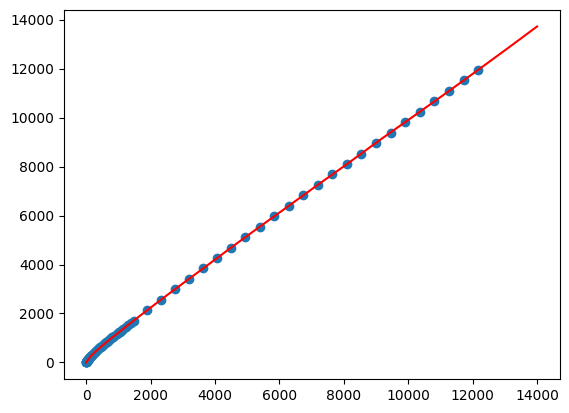

In [255]:
%matplotlib inline
import copy
plt.plot(mean_list[:80], num_photoelectrons[:80], 'o')
# Create cubic spline interpolation
from scipy.interpolate import CubicSpline
cs = CubicSpline(mean_list[:80:2], num_photoelectrons[:80:2])
x = np.linspace(0, 14000, 100)
plt.plot(x, cs(x), 'r')
plt.show()

In [349]:
%matplotlib qt
from scipy.interpolate import CubicSpline
import scipy.interpolate
def poly_func(x, *c_array):
    # Polynomial intersecting the origin
    return np.polyval(c_array[:-2], x) * x
poly_func_vec = np.vectorize(poly_func)
def rational_func(x, *c_array):
    # Rational function intersecting the origin.
    top_coeff_array = c_array[:len(c_array) // 2]
    bottom_coeff_array = c_array[len(c_array) // 2:]
    return (x * np.polyval(top_coeff_array, x)) / (np.polyval(bottom_coeff_array, x))
rational_func_vec = np.vectorize(rational_func)

# Make 2 plots: one of pixels down a column, and one of pixels across a row
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
cs_array = []
for j in range(1):
    for i in range(100):
        gray_signal_vals = [stack['mean_img'][i, j] for stack in gray_stacks]
        dark_signal_vals = [stack['mean_img'][i, j] for stack in dark_stacks]
        mean_vals = np.array(gray_signal_vals) - np.array(dark_signal_vals)
        # Set any negative values to zero
        mean_vals[mean_vals < 0] = 0
        # Throw out points where the mean value is not smaller than the next mean value
        mean_vals_good_idx = mean_vals <= np.roll(mean_vals, -1)
        # mean_vals = mean_vals[mean_vals_good_idx]
        num_photoelectrons_pixel = copy.copy(num_photoelectrons)#[mean_vals_good_idx])
        # Handle duplicates in mean_vals by averaging the corresponding num_photoelectrons
        mean_vals, indices = np.unique(mean_vals, return_inverse=True)
        num_photoelectrons_pixel = np.bincount(indices, weights=num_photoelectrons_pixel) / np.bincount(indices)
        num_photoelectrons_fit = num_photoelectrons_pixel[:90]
        mean_vals_fit = mean_vals[:90]
        mean_vals_fit_plot = np.linspace(0, 15000, 10000)
        ax[0].plot(mean_vals, num_photoelectrons_pixel, 'o', markersize=2)
        # Create a linear interpolation to fit data
        interp_func = scipy.interpolate.interp1d(mean_vals_fit, num_photoelectrons_fit, kind='linear', fill_value='extrapolate')
        ax[0].plot(mean_vals_fit_plot, interp_func(mean_vals_fit_plot), c=ax[0].lines[-1].get_color())
        # p0 = np.zeros(5)
        # popt, pcov = curve_fit(poly_func, mean_vals_fit, num_photoelectrons_fit, p0=p0)
        # ax[0].plot(mean_vals_fit_plot, poly_func_vec(mean_vals_fit_plot, *popt), c=ax[0].lines[-1].get_color())
        # Create cubic splines to fit data
        # cs = CubicSpline(mean_vals_fit, num_photoelectrons_fit)
        # cs_array.append(copy.deepcopy(cs))
        # ax[0].plot(mean_vals_fit_plot, cs(mean_vals_fit_plot), c=ax[0].lines[-1].get_color())
        # Plot residuals
        # print(popt)
        # residuals = num_photoelectrons_fit - poly_func(mean_vals_fit, *popt)
        # percent_residuals = (num_photoelectrons_fit - poly_func(mean_vals_fit, *popt)) / num_photoelectrons_fit * 100
        residuals = num_photoelectrons_fit - interp_func(mean_vals_fit)
        percent_residuals = residuals / num_photoelectrons_fit * 100
        ax[1].plot(mean_vals_fit, residuals, 'o', markersize=2)
        ax[2].plot(mean_vals_fit, percent_residuals, 'o', markersize=2)

    ax[0].set_xlabel('Mean Pixel Signal (ADU)')
    ax[0].set_ylabel('Number of Photoelectrons (e-/pixel)')
    ax[0].set_title('Linearity Plot: Column 4000, rows 4000-4100')
    # ax[1].set_xlabel('Exposure time (ms)')
    ax[1].set_xlabel('Mean signal (ADU)')
    ax[1].set_ylabel('Residuals of Linearity Fit (e-)')
    ax[1].set_ylim(-100, 100)
    ax[2].set_xlabel('Mean signal (ADU)')
    ax[2].set_ylabel('Residuals of Linearity Fit (%)')
    ax[2].set_ylim(-100, 100)
    label_plot(gray_stacks[0])
    plt.show()

NameError: name 'np' is not defined

Want to create a calibration so that we can go from measured signal (ADU) to number of photoelectrons, using our data of measured signal vs. exposure time and our Cd-109 x-ray data. From the x-ray data, we know that on average, for the 22.103 keV line that produces 22103/3.66=6039 photoelectrons, we saw a mean measured signal of 5915 ADU for the HS_HG_RS mode.

Therefore, if we interpolate to find the exposure time that yields an average of 5915 ADU for the HS_HG_RS, then we can say that this exposure time corresponds to 6039 photoelectrons, and we can calibrate the exposure time values to number of photoelectrons (since they are proportional).

Note: it takes ~1 second to take an image to a power greater than 2. Maybe faster on GPUs? Otherwise we really can't do the calibration in real-time with a high-order polynomial (or rational fit).

Yes, with my GPU on my home PC, it takes ~0.5 ms to do this exponentiation. So our calibration procedure is going to have to rely on using GPUs.

A few notes on various nonlinear calibration techniques:
- Polynomial fits: even at high order, don't do a good job of capturing low-signal response. Easy to implement and fast on GPUs.
- Polynomial fits with square root/power law: more complicated, better than polynomial, but still not great for low signal levels
- Rational fits: do better at capturing low-signal response, but have the potential to produce roots in the demoninator that make the calibrated number of photoelectrons go to infinity
- Cubic Splines: obviously fit the data exactly, but introduce many areas of the parameter space of signal levels where increasing signal levels calibrate to decreasing photoelectron value (cubic splines are not monotonic). A bit more complicated to implement on a GPU (can think of cubic splines for one pixel as O(100) separate cubic polynomials), but it's manageable.
- Linear Interpolation: like cubic splines, calibration is more complicated to implement on GPU, but a little less demanding. Will naturally fit the calibration data exactly, and will always be monotonically increasing, assuming the calibration data is.

In [314]:
# Create a mock array of signal values
signal_vals = np.random.normal(1000, 100, (10000, 100))
cs_array = np.array(cs_array)
# For each value of signal_vals, find the number of photoelectrons using the corresponding cs_array element
t0 = time.time()
num_photoelectrons = [cs_array[i](signal_vals[i]) for i in range(10000)]
t1 = time.time()
print((t1 - t0) * 80 * 80)

604.4662475585938
